**1. Import Libraries/ Dataset**

a. Import the required libraries and the dataset (use Google Drive if required).

b. Check the GPU available (recommended- use free GPU provided by Google Colab).

In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow import keras

print(tf.__version__)

2.4.1


In [17]:
# copy dataset
!wget --no-check-certificate \
  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz \
  -O /tmp/imagenette2-160.tgz

--2021-05-23 10:50:41--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.230.213
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.230.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99003388 (94M) [application/x-tar]
Saving to: ‘/tmp/imagenette2-160.tgz’

/tmp/imagenette2-16 100%[===================>]  94.42M  15.7MB/s    in 7.3s    

2021-05-23 10:50:49 (12.9 MB/s) - ‘/tmp/imagenette2-160.tgz’ saved [99003388/99003388]



In [18]:
import os
import tarfile

# open file
file = tarfile.open('/tmp/imagenette2-160.tgz')
  
# extract file
file.extractall('/tmp')

#close file
file.close()

In [19]:
# set directories
base_dir = '/tmp/imagenette2-160'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

**2. Data Visualization and Augmentation**

a. Plot at least two samples from each class of the dataset (use matplotlib/seaborn/any other library).

b. Apply rotation and height shift augmentation (rotation_range, height_shift_range) to the dataset separately. Print the augmented image and the original image for each class and each augmentation.

c. Bring the train and test data in the required format.

d. Print the shapes of train and test data.



In [20]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

# set image and batch size
num_img_rows=75 # image height, actual=213
num_img_cols=75 # image width, actual=160
num_color_channels=3
num_batch_size=100

train_datagen = ImageDataGenerator(
                  rescale=1.0/255.0,
                  rotation_range=40,
                  height_shift_range=0.2,
                  fill_mode='nearest'
                )

val_datagen = ImageDataGenerator(
                rescale=1.0/255.0
              )

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    batch_size=num_batch_size,
                    target_size=(num_img_rows, num_img_cols),
                    class_mode='categorical'
                  )

val_generator = val_datagen.flow_from_directory(
                  val_dir,
                  batch_size=num_batch_size,
                  target_size=(num_img_rows, num_img_cols),
                  class_mode='categorical'
                )

# print shape of training data after transformation
for train_image_batch, train_labels_batch in train_generator:
  print('Training image batch shape, after transformation:', train_image_batch.shape)
  print('Training label batch shape, after transformation:', train_labels_batch.shape)
  break

# print shape of test data after transformation
for val_image_batch, val_labels_batch in val_generator:
  print('Validation image batch shape, after transformation:', val_image_batch.shape)
  print('Validation label batch shape, after transformation:', val_labels_batch.shape)
  break

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.
Training image batch shape, after transformation: (100, 75, 75, 3)
Training label batch shape, after transformation: (100, 10)
Validation image batch shape, after transformation: (100, 75, 75, 3)
Validation label batch shape, after transformation: (100, 10)


**3. Model Building**

a. Sequential Model layers- Use AT LEAST 3 hidden layers with appropriate input for each. Choose the best number for hidden units and give reasons.

b. Add L2 regularization to all the layers.

c. Add one layer of dropout at the appropriate position and give reasons.

d. Choose the appropriate activation function for all the layers.

e. Print the model summary.

In [21]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers

# set model parameters
num_epochs=50
num_steps_per_epoch=95 # total training images/ batch size = 9465/100
num_val_steps=40 # total validation images/ batch size = 3925/100
num_dropout=0.2
num_l2_reg_penalty=0.0001
num_lr=1e-4
opt = RMSprop(lr=num_lr)
str_loss = 'categorical_crossentropy'

# build model
model = tf.keras.models.Sequential([
          # Flatten input
          tf.keras.layers.Flatten(input_shape=(num_img_rows,num_img_cols, num_color_channels)),
          # Layer 1 = input layer with regularization
          tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Add dropout
          tf.keras.layers.Dropout(num_dropout),
          # Layer 2 = hidden layer with regularization
          tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 3 = hidden layer with regularization
          tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 4 = hidden layer with regularization
          tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 5 = output layer with regularization
          tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
        ])

**4. Model Compilation**

a. Compile the model with the appropriate loss function.

b. Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.

c. Use accuracy as a metric.

**To be done:**

Give reasons for the choice of learning rate and its value. 


In [22]:
# compile model
model.compile(loss=str_loss,
              optimizer=opt,
              metrics=['accuracy']
             )

**5. Model Training**

a. Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.

b. Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

In [23]:
from timeit import default_timer as timer

# timing callback class
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

# timing callback
timing = TimingCallback()

# train model
history = model.fit(
            train_generator,
            epochs=num_epochs,
            steps_per_epoch=num_steps_per_epoch,
            validation_data=val_generator,
            validation_steps=num_val_steps,
            verbose=1,
            callbacks=[timing]
          )

# show model summary
model.summary()

# total training time
print('\n', 'Total time taken for training: {:.2f}'.format(sum(timing.logs)), 'seconds', '\n')

# save model
#model.save("vision.h5")

Epoch 1/50
95/95 [==============================] - 29s 299ms/step - loss: 2.7042 - accuracy: 0.1422 - val_loss: 2.4232 - val_accuracy: 0.2173
Epoch 2/50
95/95 [==============================] - 28s 295ms/step - loss: 2.4043 - accuracy: 0.2254 - val_loss: 2.2602 - val_accuracy: 0.2642
Epoch 3/50
95/95 [==============================] - 28s 293ms/step - loss: 2.2613 - accuracy: 0.2520 - val_loss: 2.2104 - val_accuracy: 0.2471
Epoch 4/50
95/95 [==============================] - 28s 296ms/step - loss: 2.1718 - accuracy: 0.2827 - val_loss: 2.0858 - val_accuracy: 0.3238
Epoch 5/50
95/95 [==============================] - 28s 293ms/step - loss: 2.1417 - accuracy: 0.2836 - val_loss: 2.0014 - val_accuracy: 0.3417
Epoch 6/50
95/95 [==============================] - 28s 295ms/step - loss: 2.1046 - accuracy: 0.3048 - val_loss: 2.0159 - val_accuracy: 0.3432
Epoch 7/50
95/95 [==============================] - 28s 293ms/step - loss: 2.0766 - accuracy: 0.3177 - val_loss: 1.9900 - val_accuracy: 0.3580

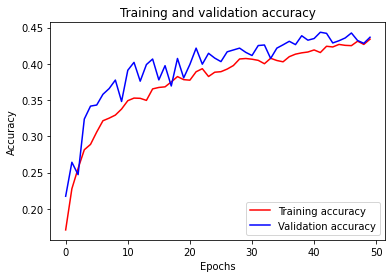

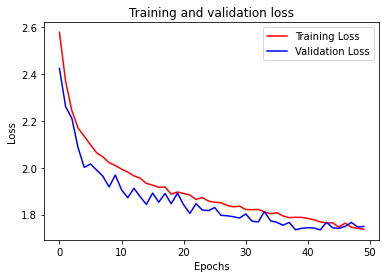

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Accuracy history graph for training and validation
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc=0)
plt.figure()

# Loss history graph for training and validation
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc=0)
plt.figure()

# show plot
plt.show()

**6. Model Evaluation**

a. Print the final train and validation loss and accuracy. Print confusion matrix and classification report for the validation dataset. Analyse and report the best and worst performing class.

b. Print the two most incorrectly classified images for each class in the test dataset.

**To be done:**

Analyse and report the best and worst performing class.

Print the two most incorrectly classified images for each class in the test dataset.


In [25]:
# final training accuracy and loss
train_score = model.evaluate(train_generator)

print("Training accuracy: {:.2f}%".format(train_score[1] * 100)) 
print("Training Loss: ",train_score[0])

# final validation accuracy and loss
val_score = model.evaluate(val_generator)

print("Validation accuracy: {:.2f}%".format(val_score[1] * 100)) 
print("Validation Loss: ",val_score[0])

95/95 [==============================] - 24s 251ms/step - loss: 1.6999 - accuracy: 0.4470
Training accuracy: 44.70%
Training Loss:  1.6999319791793823
40/40 [==============================] - 4s 97ms/step - loss: 1.7497 - accuracy: 0.4367
Validation accuracy: 43.67%
Validation Loss:  1.7496637105941772


In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# get target names
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

# print target_names
print('Target names:', target_names, '\n')

# Print Confusion Matrix 
Y_pred = model.predict(train_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix', '\n', cm, '\n')

# Print Classification Report
print('Classification Report')
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

Target names: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257'] 

Confusion Matrix 
 [[137 132  69  28  63  96 180  40 124  94]
 [133 118  84  20  57 107 164  45 133  94]
 [117 129  76  32  48 120 182  31 146 112]
 [110 121  64  35  44 108 143  33 107  93]
 [132 100  78  34  69  99 175  39 126  89]
 [139 131  70  23  52 100 169  37 138  97]
 [135 134  87  38  50  92 188  20 128  89]
 [140 129  83  29  56 101 167  29 113  84]
 [143 119  58  19  41 102 170  37 155 107]
 [140 136  66  41  57 117 163  44 111  85]] 

Classification Report
              precision    recall  f1-score   support

   n01440764       0.10      0.14      0.12       963
   n02102040       0.09      0.12      0.11       955
   n02979186       0.10      0.08      0.09       993
   n03000684       0.12      0.04      0.06       858
   n03028079       0.13      0.07      0.09       941
   n03394916       0.10      0.10      0.10       956


**Hyperparameter Tuning**

Build two more additional models by changing the following hyperparameters ONE at a time. Write the code for Model Building, Model Compilation, Model Training and Model Evaluation as given in the instructions above for each additional model.

1. Network Depth: Change the number of hidden layers and hidden units for each layer

2. Regularization: Train a model without regularization

Write a comparison between each model and give reasons for the difference in results.